# Analysis Demos

A collection of demos for the analysis service.

== Analysis Results for Revenue per User ==

Frequentist Results:
  Control Mean: 99.8890
  Variant Mean: 104.5702
  Absolute Difference: 4.6812
  Relative Difference: 468.64%
  P-value: 0.0033
  Corrected P-value: N/A

Bayesian Results:
  probability_of_improvement: 0.9986
  expected_lift: 4.7043
  credible_interval: (1.5219406105310045, 7.94563504458903)
  control_mean: 99.8890
  variant_mean: 104.5702
  sample_size: {'control': 300, 'variant': 300}

--------------------------------------------------

== Analysis Results for Conversion Rate ==

Frequentist Results:
  Control Mean: 0.1010
  Variant Mean: 0.1090
  Absolute Difference: 0.0080
  Relative Difference: 792.08%
  P-value: 0.6096
  Corrected P-value: N/A

Bayesian Results:
  probability_of_improvement: 0.6946
  expected_lift: 6.9033
  credible_interval: (-14.529563998170397, 32.50442688347701)
  control_rate: 0.1191
  variant_rate: 0.1265
  sample_size: {'control': 1000, 'variant': 1000}

-------------------------------------

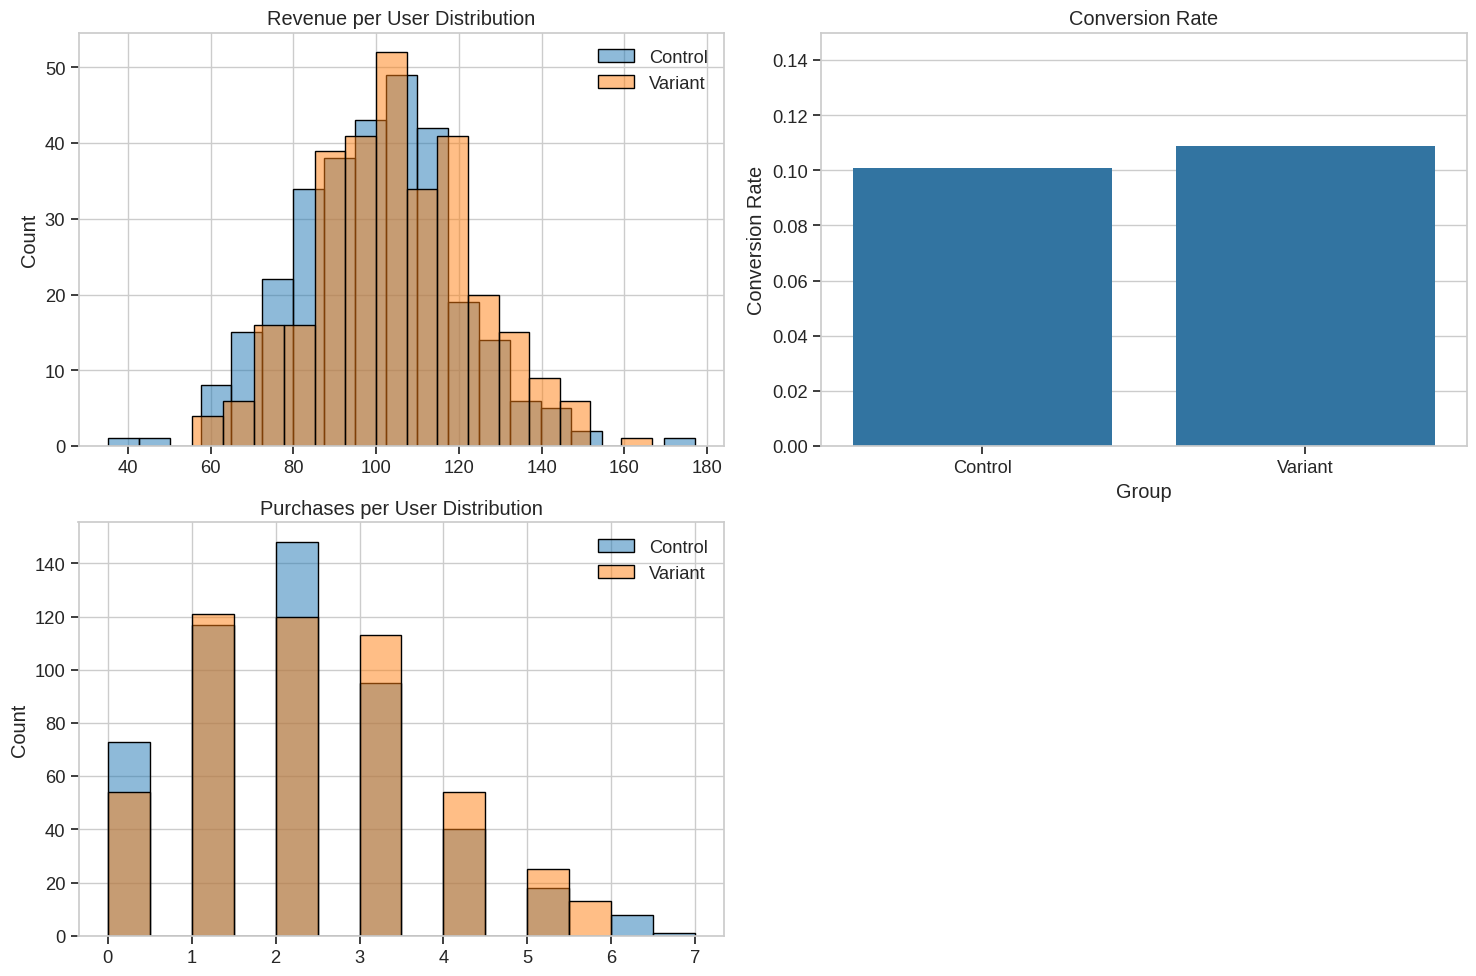

In [3]:
# Import deps
import asyncio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List

# Import our analysis modules
from lib.analysis.bayesian import BayesianAnalysisService
from lib.analysis.frequentist import StatisticalAnalysisService
from lib.analysis.correction import MultipleTestingCorrection
from lib.analysis.combined import CombinedAnalysisService, MetricType

# Set up plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Create fixture data

# 1. Continuous metric (e.g. revenue per user)
# Create control and variant with slight difference
np.random.seed(42)
control_revenue = np.random.normal(100, 20, 300)  # mean=$100, sd=$20, n=300
variant_revenue = np.random.normal(105, 20, 300)  # mean=$105, sd=$20, n=300

# 2. Binary metric (e.g. conversion rate)
control_conversion = np.random.binomial(1, 0.10, 1000)  # 10% conversion, n=1000
variant_conversion = np.random.binomial(1, 0.12, 1000)  # 12% conversion, n=1000

# 3. Count metric (e.g. number of purchases)
control_purchases = np.random.poisson(2.0, 500)  # lambda=2.0, n=500
variant_purchases = np.random.poisson(2.3, 500)  # lambda=2.3, n=500

# Initialize our analysis services
bayesian_service = BayesianAnalysisService()
frequentist_service = StatisticalAnalysisService()
correction_service = MultipleTestingCorrection()

combined_service = CombinedAnalysisService(
    frequentist_service=frequentist_service,
    bayesian_service=bayesian_service,
    correction_service=correction_service
)

# Helper function to run the async analysis
async def analyze_metric(control_data, variant_data, metric_name, metric_type, method="combined"):
    result = await combined_service.analyze_experiment(
        control_data=control_data.tolist(),
        variant_data=variant_data.tolist(),
        metric_name=metric_name,
        metric_type=metric_type,
        method=method
    )
    return result

# Function to display results in a readable format
def display_results(result):
    # Frequentist results
    freq = result.frequentist_results
    
    print(f"== Analysis Results for {result.metric_name} ==")
    print("\nFrequentist Results:")
    print(f"  Control Mean: {freq.control_mean:.4f}")
    print(f"  Variant Mean: {freq.variant_mean:.4f}")
    print(f"  Absolute Difference: {freq.absolute_difference:.4f}")
    print(f"  Relative Difference: {freq.relative_difference:.2%}")
    print(f"  P-value: {freq.p_value:.4f}")
    print(f"  Corrected P-value: {result.corrected_p_value if result.corrected_p_value is not None else 'N/A'}")
    
    # Bayesian results (if available)
    if result.bayesian_results:
        print("\nBayesian Results:")
        for key, value in result.bayesian_results.items():
            if isinstance(value, float):
                print(f"  {key}: {value:.4f}")
            else:
                print(f"  {key}: {value}")

# Run analyses
async def run_analyses():
    # Analyze revenue (continuous metric)
    revenue_result = await analyze_metric(
        control_revenue, variant_revenue, "Revenue per User", "continuous"
    )
    
    # Analyze conversion (binary metric)
    conversion_result = await analyze_metric(
        control_conversion, variant_conversion, "Conversion Rate", "binary"
    )
    
    # Analyze purchases (count metric)
    purchases_result = await analyze_metric(
        control_purchases, variant_purchases, "Purchases per User", "count"
    )
    
    # Display results
    for result in [revenue_result, conversion_result, purchases_result]:
        display_results(result)
        print("\n" + "-"*50 + "\n")
    
    # Multiple metrics analysis
    metrics_data = {
        "Revenue": {"control": control_revenue.tolist(), "variant": variant_revenue.tolist()},
        "Conversion": {"control": control_conversion.tolist(), "variant": variant_conversion.tolist()},
        "Purchases": {"control": control_purchases.tolist(), "variant": variant_purchases.tolist()}
    }
    
    metric_types = {
        "Revenue": "continuous",
        "Conversion": "binary",
        "Purchases": "count"
    }
    
    multi_results = await combined_service.analyze_multiple_metrics(
        metrics_data=metrics_data,
        metric_types=metric_types,
        correction_method="fdr_bh"
    )
    
    print("=== Multiple Metrics Analysis with FDR Correction ===\n")
    for metric_name, result in multi_results.items():
        print(f"Metric: {metric_name}")
        print(f"  Uncorrected p-value: {result.frequentist_results.p_value:.4f}")
        print(f"  Corrected p-value: {result.corrected_p_value:.4f}")
        print(f"  Significant: {result.corrected_p_value < 0.05}")
        print()
    
    return multi_results

# Run the async functions
multi_results = await run_analyses()

# Visualize the results
plt.figure(figsize=(15, 10))

# Revenue comparison
plt.subplot(2, 2, 1)
sns.histplot(control_revenue, alpha=0.5, label='Control')
sns.histplot(variant_revenue, alpha=0.5, label='Variant')
plt.title('Revenue per User Distribution')
plt.legend()

# Conversion comparison
plt.subplot(2, 2, 2)
conversion_df = pd.DataFrame({
    'Group': ['Control'] * len(control_conversion) + ['Variant'] * len(variant_conversion),
    'Converted': np.concatenate([control_conversion, variant_conversion])
})
conversion_summary = conversion_df.groupby('Group')['Converted'].mean()
sns.barplot(x=conversion_summary.index, y=conversion_summary.values)
plt.title('Conversion Rate')
plt.ylim(0, 0.15)
plt.ylabel('Conversion Rate')

# Purchases comparison
plt.subplot(2, 2, 3)
sns.histplot(control_purchases, alpha=0.5, label='Control')
sns.histplot(variant_purchases, alpha=0.5, label='Variant')
plt.title('Purchases per User Distribution')
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Bayesian analysis visualization for conversion rate
if 'Conversion' in multi_results:
    bayes_results = multi_results['Conversion'].bayesian_results
    if 'posterior_samples' in bayes_results:
        posterior_diff = bayes_results['posterior_samples']
        
        plt.figure(figsize=(10, 6))
        sns.histplot(posterior_diff, kde=True)
        plt.axvline(0, color='red', linestyle='--')
        plt.title('Posterior Distribution of Difference in Conversion Rate')
        plt.xlabel('Variant - Control Difference')
        plt.ylabel('Density')
        
        # Credible interval
        ci_low = np.percentile(posterior_diff, 2.5)
        ci_high = np.percentile(posterior_diff, 97.5)
        plt.axvline(ci_low, color='green', linestyle='--', label=f'95% CI: [{ci_low:.4f}, {ci_high:.4f}]')
        plt.axvline(ci_high, color='green', linestyle='--')
        plt.legend()
        
        plt.show()